# Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

# Download file

In [3]:
file_id = "1DopC7bm_EWX_ocqbOIkME9usE5rG3pZE"
file_name = 'Customer_data_2021&2022.csv'

%run download.ipynb

# Import data

In [4]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
0,2021-01-01,Fri,13154,67.00,1118.00,NaN,37.00,1081.00,1118.00,443.55,271.25,0.40,0.24,288
1,2021-01-01,Fri,18379,54.00,40.00,NaN,40.00,NaN,40.00,0.00,40.00,0.00,1.00,1
2,2021-01-01,Fri,559232,63.00,12.00,NaN,NaN,12.00,12.00,9.50,2.04,0.79,0.17,5
3,2021-01-01,Fri,698904,69.00,1223.50,NaN,NaN,1223.50,1223.50,267.91,245.12,0.22,0.20,40
4,2021-01-01,Fri,762921,67.00,17.50,NaN,NaN,17.50,17.50,0.00,3.50,0.00,0.20,5


In [5]:
#

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

In [6]:
df.isna().sum()

DATE_DIM                       0
DAY_OF_WEEK                    0
BET_ACCOUNT_NUM_HASH           0
AGE                         2676
RACING_TURNOVER           959303
SPORT_TURNOVER          10575105
FOB_TURNOVER             2701974
PARI_TURNOVER            3829864
TURNOVER                       0
DIVIDENDS_PAID                 0
GROSS_MARGIN                   0
WIN_LOSS_RATIO                 0
MARGIN_RATE                    0
TICKETS                        0
dtype: int64

In [7]:
df_missing_age = df[df['AGE'].isna()]
df_missing_age

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
5146,2021-01-01,Fri,1080370257,NaN,40.00,NaN,NaN,40.00,40.00,0.00,8.00,0.00,0.20,5
5769,2021-01-01,Fri,1208532057,NaN,27.50,NaN,5.00,22.50,27.50,14.60,6.96,0.53,0.25,40
13807,2021-01-01,Fri,2969320105,NaN,108.00,NaN,NaN,108.00,108.00,92.20,16.94,0.85,0.16,31
16048,2021-01-01,Fri,3461584997,NaN,33.50,NaN,25.00,8.50,33.50,73.15,-42.92,2.18,-1.28,7
16290,2021-01-01,Fri,3512123314,NaN,0.50,NaN,NaN,0.50,0.50,0.00,0.10,0.00,0.20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12346714,2022-12-31,Sat,1208532057,NaN,7.50,NaN,1.00,6.50,7.50,24.36,2.15,3.25,0.29,7
12352173,2022-12-31,Sat,2100229039,NaN,4.00,NaN,NaN,4.00,4.00,0.00,0.61,0.00,0.15,2
12357658,2022-12-31,Sat,2969320105,NaN,31.00,NaN,5.00,26.00,31.00,16.90,9.01,0.55,0.29,14
12360763,2022-12-31,Sat,3461584997,NaN,51.00,NaN,33.00,18.00,51.00,53.20,-5.89,1.04,-0.12,60


In [8]:
missing_age_lst = df_missing_age['BET_ACCOUNT_NUM_HASH'].unique()

df[df['BET_ACCOUNT_NUM_HASH'].isin(missing_age_lst)].groupby('BET_ACCOUNT_NUM_HASH', as_index=False).AGE.min()

,BET_ACCOUNT_NUM_HASH,AGE
0,708049310,NaN
1,786895907,NaN
2,1080370257,NaN
3,1208532057,NaN
4,2100229039,NaN
5,2969320105,NaN
6,3111443700,NaN
7,3387748523,NaN
8,3461584997,NaN
9,3512123314,NaN


# Customer

In [9]:
cus_df = df.groupby('BET_ACCOUNT_NUM_HASH', as_index=False) \
            .agg({'AGE': 'max', 
                  'RACING_TURNOVER' : 'sum', 
                  'SPORT_TURNOVER' : 'sum', 
                  'FOB_TURNOVER' : 'sum', 
                  'PARI_TURNOVER' : 'sum', 
                  'TURNOVER' : 'sum', 
                  'DIVIDENDS_PAID' : 'sum',
                  'GROSS_MARGIN' : 'sum', 
                  'TICKETS' : 'sum'})

cus_df

,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,13154,67.00,366186.08,0.00,31113.00,335073.08,366186.08,270817.07,81925.97,113627
1,18379,54.00,31934.00,99.00,28021.00,4012.00,32033.00,23658.86,6645.73,841
2,37251,22.00,100.00,0.00,65.00,35.00,100.00,760.00,-689.65,7
3,129273,22.00,62.00,93.00,155.00,0.00,155.00,149.45,5.55,37
4,348318,29.00,25.00,5.00,27.00,3.00,30.00,0.00,27.58,17
...,...,...,...,...,...,...,...,...,...,...
144872,4294834703,47.00,175672.30,100.00,163650.50,12121.80,175772.30,141583.30,32669.97,1905
144873,4294891076,67.00,71712.91,331.00,1536.00,70507.91,72043.91,51175.39,15301.44,32283
144874,4294928673,38.00,8.00,0.00,1.00,7.00,8.00,0.00,2.38,4
144875,4294964456,21.00,67.00,0.00,29.00,38.00,67.00,7.40,30.33,24


In [10]:
cus_df.describe()

,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
count,144867.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00,144877.00
mean,43.68,13580.20,1575.24,8892.53,6262.92,15155.45,12527.94,2365.19,1888.08
std,15.93,55655.85,22389.91,47384.05,28982.81,61888.19,54219.50,9365.80,8881.82
min,18.00,0.00,0.00,0.00,0.00,0.00,0.00,-327327.36,1.00
25%,31.00,100.00,0.00,75.00,11.00,163.00,73.10,20.00,17.00
50%,41.00,722.00,5.00,491.00,138.00,992.50,738.18,150.00,101.00
75%,55.00,5965.00,139.00,3605.00,1492.50,7070.00,5905.03,1060.38,700.00
max,104.00,5234120.84,2849523.33,4399559.00,3599772.50,5544861.46,4507251.65,467391.88,699955.00


In [11]:
age_mean = round(cus_df['AGE'].mean()) ## 44

cus_df.fillna(age_mean, inplace=True)

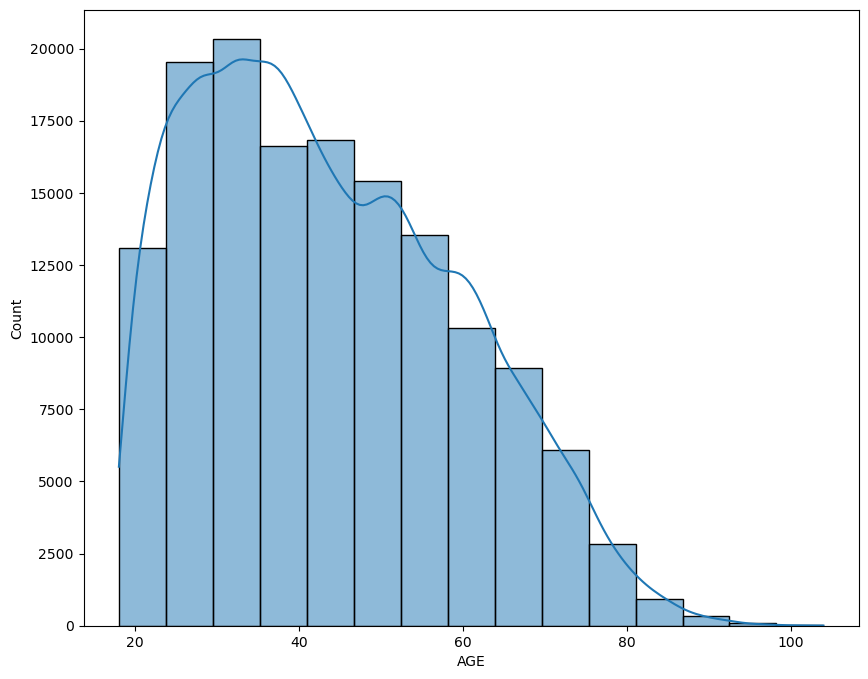

In [12]:
fig, axe = plt.subplots(1, figsize=(10,8))

sns.histplot(cus_df['AGE'], kde=True, bins=15)

plt.show();

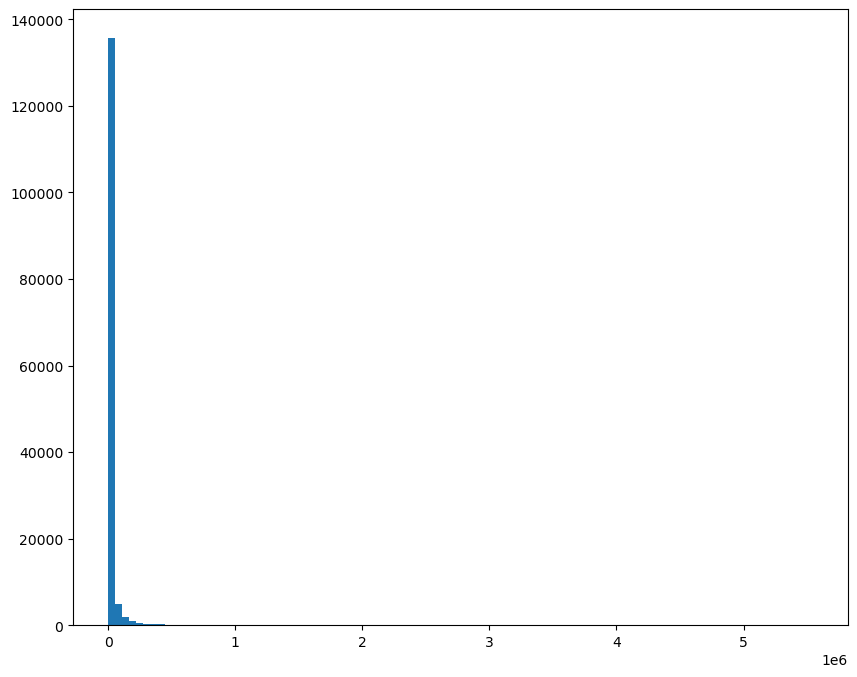

In [13]:
fig, axe = plt.subplots(1, figsize=(10,8))

plt.hist(cus_df['TURNOVER'], bins=100)

plt.show();

In [14]:
df_agg = df.copy()
df_agg.index = pd.to_datetime(df_agg['DATE_DIM'])

In [15]:
df_sum = df_agg.resample('d').TURNOVER.sum()
df_sum

DATE_DIM
2021-01-01   3837745.01
2021-01-02   6169945.03
2021-01-03   2207583.19
2021-01-04   1529894.67
2021-01-05   1482174.82
                ...    
2022-12-27   2416513.24
2022-12-28   3381936.07
2022-12-29   2864956.49
2022-12-30   3002987.42
2022-12-31   5811181.70
Freq: D, Name: TURNOVER, Length: 730, dtype: float64

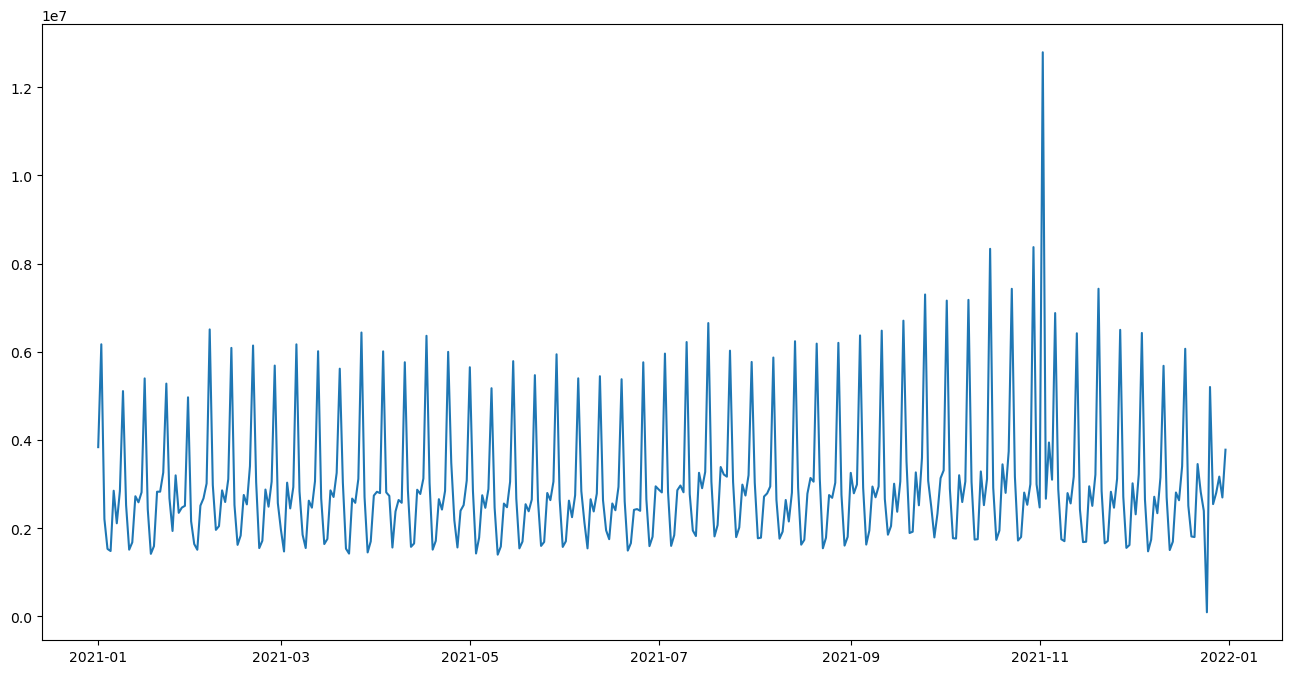

In [16]:
fig, ax = plt.subplots(1, figsize=(16,8))

ax.plot(df_sum[:365])

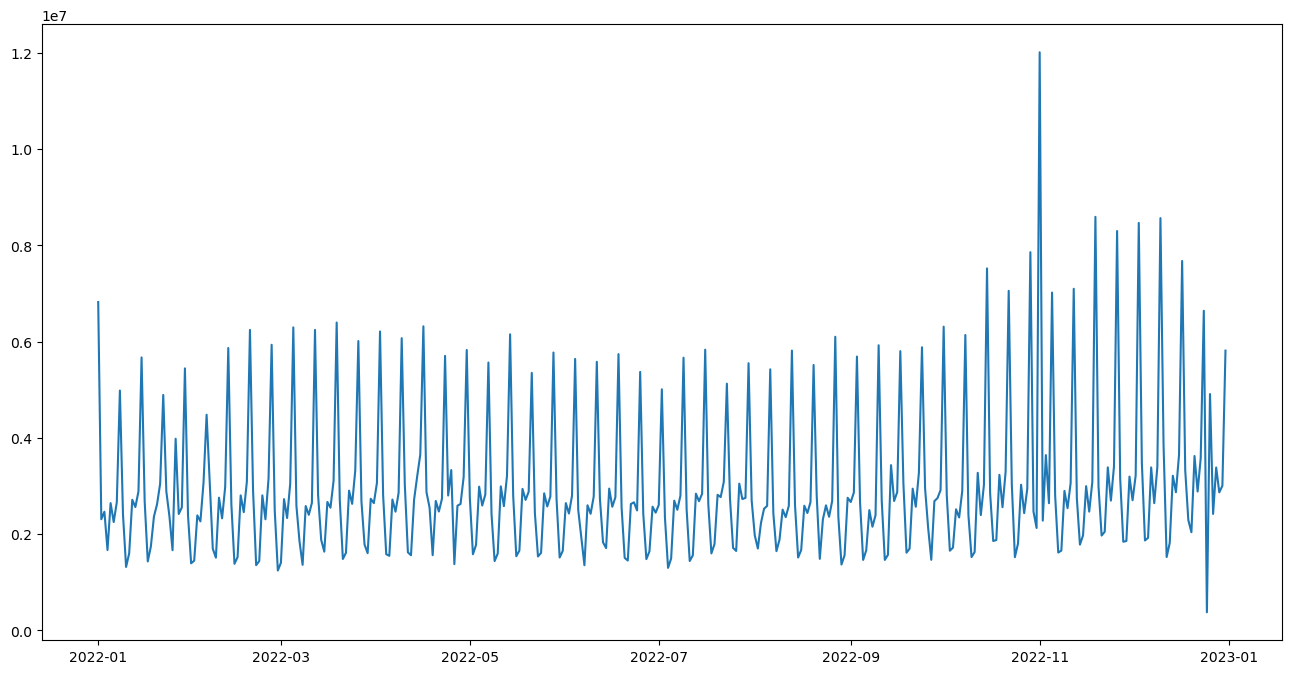

In [17]:
fig, ax = plt.subplots(1, figsize=(16,8))

ax.plot(df_sum[365:])

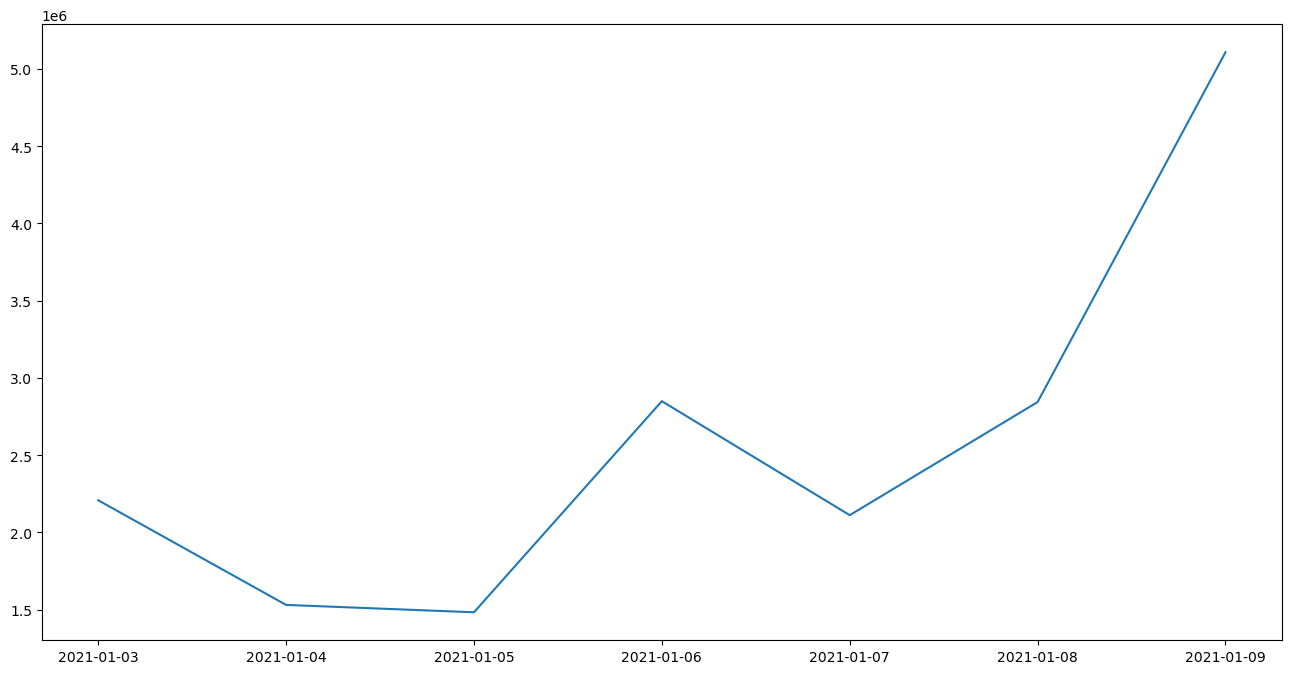

In [18]:
fig, ax = plt.subplots(1, figsize=(16,8))

ax.plot(df_sum[2:9])

In [19]:
df_firstyear = df_sum[365:]
df_firstyear.argmax()

304

In [20]:
df_firstyear.argmin()

358

In [21]:
df_firstyear[358:359]

DATE_DIM
2022-12-25   372355.49
Freq: D, Name: TURNOVER, dtype: float64

In [22]:
df_firstyear[304:305]

DATE_DIM
2022-11-01   12012422.99
Freq: D, Name: TURNOVER, dtype: float64

In [23]:
df_2ndyear = df_sum[:365]
df_2ndyear.argmax()

305

In [24]:
df_2ndyear.argmin()

358

In [25]:
df_2ndyear[358:359]

DATE_DIM
2021-12-25   93015.86
Freq: D, Name: TURNOVER, dtype: float64

In [26]:
df_2ndyear[305:306]

DATE_DIM
2021-11-02   12792169.92
Freq: D, Name: TURNOVER, dtype: float64

In [27]:
df_max = df[df['DATE_DIM'] == '2021-11-02']

In [28]:
df_max[df_max['RACING_TURNOVER'] > 0 ]

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
5092071,2021-11-02,Tue,13154,67.00,2138.24,NaN,305.00,1833.24,2138.24,1651.10,691.89,0.77,0.32,616
5092072,2021-11-02,Tue,18379,54.00,340.00,NaN,250.00,90.00,340.00,152.00,114.31,0.45,0.34,9
5092073,2021-11-02,Tue,368326,36.00,22.00,NaN,20.00,2.00,22.00,0.00,20.43,0.00,0.93,13
5092074,2021-11-02,Tue,406536,39.00,23.00,NaN,17.00,6.00,23.00,41.25,-23.05,1.79,-1.00,6
5092075,2021-11-02,Tue,559232,63.00,36.00,NaN,13.00,23.00,36.00,0.00,16.97,0.00,0.47,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155511,2021-11-02,Tue,4294707367,55.00,216.00,NaN,70.00,146.00,216.00,108.99,95.99,0.50,0.44,15
5155512,2021-11-02,Tue,4294749281,33.00,460.00,NaN,NaN,460.00,460.00,409.65,95.14,0.89,0.21,57
5155513,2021-11-02,Tue,4294834703,47.00,2199.30,NaN,2008.00,191.30,2199.30,0.00,2046.34,0.00,0.93,17
5155514,2021-11-02,Tue,4294891076,67.00,572.00,NaN,20.00,552.00,572.00,681.98,140.93,1.19,0.25,194


In [29]:
df_max

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,RACING_TURNOVER,SPORT_TURNOVER,FOB_TURNOVER,PARI_TURNOVER,TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,WIN_LOSS_RATIO,MARGIN_RATE,TICKETS
5092071,2021-11-02,Tue,13154,67.00,2138.24,NaN,305.00,1833.24,2138.24,1651.10,691.89,0.77,0.32,616
5092072,2021-11-02,Tue,18379,54.00,340.00,NaN,250.00,90.00,340.00,152.00,114.31,0.45,0.34,9
5092073,2021-11-02,Tue,368326,36.00,22.00,NaN,20.00,2.00,22.00,0.00,20.43,0.00,0.93,13
5092074,2021-11-02,Tue,406536,39.00,23.00,NaN,17.00,6.00,23.00,41.25,-23.05,1.79,-1.00,6
5092075,2021-11-02,Tue,559232,63.00,36.00,NaN,13.00,23.00,36.00,0.00,16.97,0.00,0.47,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155511,2021-11-02,Tue,4294707367,55.00,216.00,NaN,70.00,146.00,216.00,108.99,95.99,0.50,0.44,15
5155512,2021-11-02,Tue,4294749281,33.00,460.00,NaN,NaN,460.00,460.00,409.65,95.14,0.89,0.21,57
5155513,2021-11-02,Tue,4294834703,47.00,2199.30,NaN,2008.00,191.30,2199.30,0.00,2046.34,0.00,0.93,17
5155514,2021-11-02,Tue,4294891076,67.00,572.00,NaN,20.00,552.00,572.00,681.98,140.93,1.19,0.25,194


In [30]:
df_sum['WEEK_DAY'] = df_sum.index.weekday

In [31]:
df_sum.to_frame()

,TURNOVER
DATE_DIM,
2021-01-01 00:00:00,3837745.01
2021-01-02 00:00:00,6169945.03
2021-01-03 00:00:00,2207583.19
2021-01-04 00:00:00,1529894.67
2021-01-05 00:00:00,1482174.82
...,...
2022-12-28 00:00:00,3381936.07
2022-12-29 00:00:00,2864956.49
2022-12-30 00:00:00,3002987.42
